In [1]:
import numpy as np
import XNLdyn
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing import Pool

%matplotlib notebook

In [2]:
import warnings
warnings.filterwarnings('default')

In [3]:

## Set up the problem
PAR = XNLdyn.XNLpars()

N_local_fluences_to_calculate = 30
N_pulse_energies = 20
Nsteps_r = 100

pulse_energy_J = 3e-13# J


PAR.N_photens = 3
PAR.t0_i       = [3, 0,0]   # Arrival time on time-axis / fs
PAR.tdur_sig_i = [1,3,5]  # Rms pulse duration / fs
PAR.E_i_abs    = [848,851.2,852,] # Photon Energies of incident pulses / eV
PAR.lambda_res_Ei = (10,10,10)


PAR.I0_i =  [.4* XNLdyn.photons_per_J(PAR.E_i_abs[0])*pulse_energy_J,
             1*XNLdyn.photons_per_J(PAR.E_i_abs[1])*pulse_energy_J,
             1*XNLdyn.photons_per_J(PAR.E_i_abs[2])*pulse_energy_J]

print(*zip(PAR.E_i_abs,PAR.I0_i))


(848, 883.2324161972778) (851.2, 2199.779983949987) (852, 2197.7144628382966)


In [4]:
sim = XNLdyn.XNLsim(PAR, DEBUG=True, load_tables = False)

sim.par.I0_i

Energy 0.50 too close to others to satisfy the resonant bandwidth of 0.80
Energy 1.30 too close to others to satisfy the resonant bandwidth of 0.80
Starting to generate lookup tables for T between 296.0 to 1740972.7 and mu_chem between -160.0 and 25.0
Lookup tables generated.


[883.2324161972778, 2199.779983949987, 2197.7144628382966]

In [5]:
tb =  {'size': 400,
                     'chem_pot_minstep': 0.005,
                     'chem_pot_min': -80,
                     'chem_pot_max': 25,
                     'T_max': 1e8} 
N=400
temperatures = np.logspace(0, np.log10(tb['T_max']), N - 1) + 295
fermis_upper = np.logspace(np.log10(tb['chem_pot_minstep']), np.log10(tb['chem_pot_max']), int(N / 2))
fermis_lower = np.logspace(np.log10(tb['chem_pot_minstep']), np.log10(-tb['chem_pot_min']), int(N / 2))
fermis = np.concatenate((-fermis_lower[::-1], fermis_upper[1:]))

In [6]:
%%time

PAR.FermiSolver.plot_lookup_tables()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CPU times: user 805 ms, sys: 821 ms, total: 1.63 s
Wall time: 780 ms


In [ ]:
%%time
sim_options = dict(t_span=[-25, 80],
                   method='RK45',
                   rtol=1e-2, atol=1e-8, 
                   plot = True,
                   return_full_solution = True)

incident, transmitted, sol = sim.run(**sim_options)

print('Transmission: ', 100 * transmitted/incident, ' %')


t:  -25.0
-23.985591321180365 9.999987627022968 -> 307.6811104942512 0.007687527302948638
Photons impinging per atom this timestep:  [2.01163026e-168 2.43499765e-013 6.53476996e-004] i.e.  [2.20090838e-170 2.66411122e-015 7.14963891e-006] /atom
t:  -24.909887673917336
-23.985591229291916 9.999987688059132 -> 310.76571334499783 0.010845260915232302
Photons impinging per atom this timestep:  [2.49788754e-167 3.12616397e-013 7.14981918e-004] i.e.  [2.73291853e-169 3.42031069e-015 7.82255928e-006] /atom
t:  -24.984607384154042
-23.985591305484363 9.999987637448914 -> 307.6811104942512 0.007687527302948638
Photons impinging per atom this timestep:  [3.09510009e-168 2.54133592e-013 6.63610385e-004] i.e.  [3.38632395e-170 2.78045505e-015 7.26050750e-006] /atom
Deviation from energy conservation (%):  inf
t:  -24.97691107623106
-23.985591297332036 9.99998764283701 -> 307.6811104942512 0.007687527302948638
Photons impinging per atom this timestep:  [3.83883442e-168 2.59620840e-013 6.68733479e-0

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:798: RuntimeWarning: divide by zero encountered in double_scalars
  ec_error = np.abs(is_new_energy - should_be_new_energy)[check_z_index] / energy_incoming[check_z_index]


 [1.12573695e-167 2.88857774e-013 6.94923645e-004] i.e.  [1.23165968e-169 3.16036952e-015 7.60310334e-006] /atom
t:  -24.931588374017963
-23.985591244315394 9.999987674916984 -> 310.76571334499783 0.010845260915232302
Photons impinging per atom this timestep:  [1.36280602e-167 2.94384950e-013 6.99681586e-004] i.e.  [1.49103504e-169 3.22084190e-015 7.65515958e-006] /atom
t:  -24.92303692077021
-23.98559123438101 9.999987681129037 -> 310.76571334499783 0.010845260915232302
Photons impinging per atom this timestep:  [1.73042135e-167 3.01440677e-013 7.05672991e-004] i.e.  [1.89323999e-169 3.29803804e-015 7.72071106e-006] /atom
t:  -24.92303692077021
-23.98559123845901 9.999987681131978 -> 310.76571334499783 0.010845260915232302
Photons impinging per atom this timestep:  [1.73042135e-167 3.01440677e-013 7.05672991e-004] i.e.  [1.89323999e-169 3.29803804e-015 7.72071106e-006] /atom
t:  -24.888450841461154
-23.985591199249185 9.999987706359358 -> 310.76571334499783 0.010845260915232302
Photon

-23.98497457309111 10.000216922828754 -> 652.2902388307818 0.14326496764655872
Photons impinging per atom this timestep:  [1.28624808e-98 1.59468738e-06 1.85803559e-01] i.e.  [1.40727361e-100 1.74473455e-008 2.03286169e-003] /atom
t:  -18.36212475859048
-23.98490155497063 10.000244668015835 -> 679.1845812610269 0.14326496764655872
Photons impinging per atom this timestep:  [2.84401494e-97 2.14370921e-06 2.06685753e-01] i.e.  [3.11161372e-99 2.34541489e-08 2.26133209e-03] /atom
t:  -18.36212475859048
-23.984912026468166 10.00024853664636 -> 679.1845812610269 0.14326496764655872
Photons impinging per atom this timestep:  [2.84401494e-97 2.14370921e-06 2.06685753e-01] i.e.  [3.11161372e-99 2.34541489e-08 2.26133209e-03] /atom
t:  -18.102124758590477
-23.984768788532783 10.000301575112806 -> 708.1033441643868 0.14326496764655872
Photons impinging per atom this timestep:  [7.10216037e-95 3.63003914e-06 2.49838232e-01] i.e.  [7.77041616e-97 3.97159644e-08 2.73345987e-03] /atom
t:  -17.972124

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:22: UserWarning: Found value up to -1.405e-06 under minimum of -1e-05.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)


Photons impinging per atom this timestep:  [7.37252812e-88 1.68490495e-05 4.34168162e-01] i.e.  [8.06622333e-90 1.84344086e-07 4.75019871e-03] /atom
t:  -17.206569203034924
-23.983863751457232 10.000606827766687 -> 772.635139245562 0.14684659070746875
Photons impinging per atom this timestep:  [7.66629507e-87 2.10302091e-05 4.70234533e-01] i.e.  [8.38763137e-89 2.30089815e-07 5.14479796e-03] /atom
t:  -17.06212475859048
-23.98367345125459 10.000676566266621 -> 808.5882149359508 0.14684659070746875
Photons impinging per atom this timestep:  [1.40488835e-85 2.76867961e-05 5.19169296e-01] i.e.  [1.53707697e-87 3.02918995e-07 5.68018923e-03] /atom
t:  -17.06212475859048
-23.983706250258823 10.000684951704761 -> 808.5882149359508 0.14684659070746875
Photons impinging per atom this timestep:  [1.40488835e-85 2.76867961e-05 5.19169296e-01] i.e.  [1.53707697e-87 3.02918995e-07 5.68018923e-03] /atom
t:  -16.802124758590477
-23.983333841477464 10.000817429632317 -> 808.5882149359508 0.1561361043

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:22: UserWarning: Found value up to -1.064e-05 under minimum of -1e-05.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:22: UserWarning: Found value up to -5.123e-06 under minimum of -1e-05.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)


-23.981461875943364 10.001442461010894 -> 933.5154181497247 0.1561361043699776
Photons impinging per atom this timestep:  [9.42237179e-77 1.87258505e-04 1.03316524e+00] i.e.  [1.03089407e-78 2.04878014e-06 1.13037772e-02] /atom
t:  -15.906569203034922
-23.98098574658433 10.001551597297642 -> 933.5154181497247 0.1561361043699776
Photons impinging per atom this timestep:  [8.43118556e-76 2.29858608e-04 1.11228660e+00] i.e.  [9.22449186e-78 2.51486442e-06 1.21694376e-02] /atom
t:  -15.762124758590478
-23.980525736804303 10.001714830406822 -> 981.5784505496695 0.16003950551615276
Photons impinging per atom this timestep:  [1.28054273e-74 2.96366205e-04 1.21884688e+00] i.e.  [1.40103144e-76 3.24251865e-06 1.33353051e-02] /atom
t:  -15.762124758590478
-23.980690498758072 10.001731675199936 -> 933.5154181497247 0.16003950551615276
Photons impinging per atom this timestep:  [1.28054273e-74 2.96366205e-04 1.21884688e+00] i.e.  [1.40103144e-76 3.24251865e-06 1.33353051e-02] /atom
t:  -15.5021247

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:22: UserWarning: Found value up to -3.929e-04 under minimum of -1e-05.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:25: UserWarning: Found values 1.450e-04 over maximum of 1.00001.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:22: UserWarning: Found value up to -7.734e-06 under minimum of -1e-05.valence occupation deviation in proc_nonres_inter()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:22: UserWarning: Found value up to -3.162e-04 under minimum of -1e-05.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:25: UserWarning: Found values 1.179e-04 over maximum of 1.00001.Valence occupation in p

-23.953857352604523 10.010205518657582 -> 1614.3474592557848 0.2021125770239678
Photons impinging per atom this timestep:  [4.31835203e-53 2.81703877e-02 6.28081851e+00] i.e.  [4.72467399e-55 3.08209931e-04 6.87179268e-02] /atom
t:  -12.772124758590476
-23.95094944669345 10.011070676253334 -> 1614.3474592557848 0.2021125770239678
Photons impinging per atom this timestep:  [3.38419133e-52 3.39095431e-02 6.71439250e+00] i.e.  [3.70261634e-54 3.71001565e-04 7.34616247e-02] /atom
t:  -12.122124758590475
-23.934546330471715 10.015696190990036 -> 1917.263453968459 0.22302942912477874
Photons impinging per atom this timestep:  [7.76328602e-48 8.33172401e-02 9.28015825e+00] i.e.  [8.49374839e-50 9.11567178e-04 1.01533460e-01] /atom
t:  -12.00656920303492
-23.93048115451953 10.016601675895314 -> 1935.2706879176842 0.225777432711169
Photons impinging per atom this timestep:  [4.42641319e-47 9.72763356e-02 9.81235879e+00] i.e.  [4.84290284e-49 1.06429251e-03 1.07356223e-01] /atom
t:  -11.86212475

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:22: UserWarning: Found value up to -2.755e-03 under minimum of -1e-05.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:25: UserWarning: Found values 1.038e-03 over maximum of 1.00001.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:22: UserWarning: Found value up to -1.117e-04 under minimum of -1e-05.valence occupation deviation in proc_nonres_inter()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:22: UserWarning: Found value up to -2.292e-03 under minimum of -1e-05.Valence occupation in proc_res_inter_Ej()
  warnings.warn(string)
/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:25: UserWarning: Found values 8.785e-04 over maximum of 1.00001.Valence occupation in p

2058.73894095391 0.24006011306363462
Photons impinging per atom this timestep:  [3.82740854e-46 1.17812532e-01 1.05128330e+01] i.e.  [4.18753669e-48 1.28897738e-03 1.15020054e-01] /atom
t:  -11.602124758590476
-23.91809456834284 10.02041309070168 -> 2162.6099971980484 0.24306672270418517
Photons impinging per atom this timestep:  [1.76362298e-44 1.65343099e-01 1.18770836e+01] i.e.  [1.92956562e-46 1.80900545e-03 1.29946210e-01] /atom
t:  -11.472124758590475
-23.91249976963277 10.021928257918786 -> 2334.256536021021 0.26162746890670974
Photons impinging per atom this timestep:  [1.16720421e-43 1.95326020e-01 1.26114338e+01] i.e.  [1.27702868e-45 2.13704617e-03 1.37980676e-01] /atom
t:  -10.822124758590475
-23.880981537510603 10.029876621701925 -> 2652.8133493142595 0.29226077070566703
Photons impinging per atom this timestep:  [1.15016114e-39 4.36915660e-01 1.68513216e+01] i.e.  [1.25838199e-41 4.78025886e-03 1.84368945e-01] /atom
t:  -10.706569203034919
-23.872702931205133 10.031369178

-22.360709760987394 10.245988821734946 -> 13345.157111735365 1.7951600838071897
Photons impinging per atom this timestep:  [8.03450414e-10 1.03621172e+02 1.20684720e+02] i.e.  [8.79048593e-12 1.13371085e+00 1.32040175e+00] /atom
t:  -4.2065692030349195
-22.277287492362486 10.252005351267382 -> 13699.178700950319 1.8485713724867026
Photons impinging per atom this timestep:  [1.86003600e-09 1.09452841e+02 1.23087106e+02] i.e.  [2.03505033e-11 1.19751467e+00 1.34668606e+00] /atom
t:  -4.062124758590475
-22.1922074746602 10.258903466113741 -> 14034.132692094956 1.8925641516238159
Photons impinging per atom this timestep:  [5.21277649e-09 1.16961813e+02 1.26062728e+02] i.e.  [5.70325655e-11 1.27966973e+00 1.37924210e+00] /atom
t:  -4.062124758590475
-22.215105300842723 10.258039423952212 -> 13976.525443245737 1.8816973635147747
Photons impinging per atom this timestep:  [5.21277649e-09 1.16961813e+02 1.26062728e+02] i.e.  [5.70325655e-11 1.27966973e+00 1.37924210e+00] /atom
t:  -3.802124758

Photons impinging per atom this timestep:  [336.6386702  195.23402788 151.59707166] i.e.  [3.68313644 2.13603969 1.65861129] /atom
t:  2.8278752414095254
-11.604996277258262 10.116988114081009 -> 43930.22647264759 4.020308502458306
Photons impinging per atom this timestep:  [347.17757012 187.59601306 149.43465479] i.e.  [3.79844169 2.05247279 1.63495246] /atom
t:  3.4778752414095253
-9.75830730600887 10.069956524093174 -> 48230.42926806798 4.147835538617471
Photons impinging per atom this timestep:  [314.33756983 149.39340488 137.67343246] i.e.  [3.4391419  1.63450115 1.50627388] /atom
t:  3.5934307969650803
-9.412692554758474 10.065149646655819 -> 49022.34892087692 4.166376362984238
Photons impinging per atom this timestep:  [295.47073292 142.76316792 135.44177935] i.e.  [3.23272137 1.56196026 1.48185754] /atom
t:  3.737875241409525
-8.986018355353353 10.058021599322188 -> 49984.16705467158 4.191220082395262
Photons impinging per atom this timestep:  [268.38430006 134.60648835 132.603

13.870607874319003 9.955180098351406 -> 91104.25803597998 4.652964754673889
Photons impinging per atom this timestep:  [8.17307748e-11 5.50716883e-01 1.83157644e+01] i.e.  [8.94209790e-13 6.02534883e-03 2.00391295e-01] /atom
t:  11.277875241409527
16.13871664368844 9.950143477992517 -> 94598.08978885598 4.606074619987112
Photons impinging per atom this timestep:  [4.64897515e-13 2.49679942e-01 1.37768187e+01] i.e.  [5.08640607e-15 2.73172803e-03 1.50731058e-01] /atom
t:  11.393430796965083
16.54165832370108 9.949272047211315 -> 95195.73708662411 4.603742936097831
Photons impinging per atom this timestep:  [1.77431739e-13 2.15861215e-01 1.30735547e+01] i.e.  [1.94126629e-15 2.36172007e-03 1.43036704e-01] /atom
t:  11.537875241409527
17.047740062305365 9.948180470595798 -> 95988.31509151688 4.583497508374677
Photons impinging per atom this timestep:  [5.22358698e-14 1.79579683e-01 1.22355478e+01] i.e.  [5.71508423e-16 1.96476677e-03 1.33868138e-01] /atom
t:  11.537875241409527
17.0496064

40.096543745540984 9.90484692544093 -> 128593.93004944874 3.6541201924852658
Photons impinging per atom this timestep:  [2.76572644e-47 4.12985453e-06 2.61714231e-01] i.e.  [3.02595891e-49 4.51844041e-08 2.86339421e-03] /atom
t:  18.297875241409532
41.02600627156352 9.903304304233428 -> 129899.72591559283 3.5902227441197
Photons impinging per atom this timestep:  [5.35926024e-49 2.44340475e-06 2.16655229e-01] i.e.  [5.86352324e-51 2.67330935e-08 2.37040732e-03] /atom
t:  18.42787524140953
41.49136994302536 9.902549330844673 -> 130518.13394377475 3.5652817793492204
Photons impinging per atom this timestep:  [7.27349750e-50 1.87414194e-06 1.96924486e-01] i.e.  [7.95787472e-52 2.05048352e-08 2.15453485e-03] /atom
t:  19.07787524140953
43.816723280546185 9.898791269622052 -> 133613.06480395608 3.4370287941032984
Photons impinging per atom this timestep:  [2.59921305e-54 4.83732409e-07 1.20934077e-01] i.e.  [2.84377796e-56 5.29247712e-09 1.32312994e-03] /atom
t:  19.193430796965085
44.22810

Photons impinging per atom this timestep:  [7.14347800e-109 4.80073807e-014 3.64218257e-004] i.e.  [7.81562145e-111 5.25244865e-016 3.98488246e-006] /atom
t:  25.69343079696509
67.57467348948528 9.865427278316512 -> 165265.26925053075 1.7170948178118977
Photons impinging per atom this timestep:  [5.22319564e-110 3.45430246e-014 3.23519571e-004] i.e.  [5.71465606e-112 3.77932436e-016 3.53960143e-006] /atom
t:  25.837875241409535
68.0945313575636 9.864791874907084 -> 165990.61844290618 1.6667436469969346
Photons impinging per atom this timestep:  [1.94901165e-111 2.28438700e-014 2.78771205e-004] i.e.  [2.13239786e-113 2.49932933e-016 3.05001318e-006] /atom
t:  25.837875241409535
68.0983364619565 9.864793862662147 -> 166005.92993650844 1.6644391213235679
Photons impinging per atom this timestep:  [1.94901165e-111 2.28438700e-014 2.78771205e-004] i.e.  [2.13239786e-113 2.49932933e-016 3.05001318e-006] /atom
t:  26.097875241409536
69.03328170887524 9.863653202157625 -> 167223.7371160917 1.5

Photons impinging per atom this timestep:  [4.40409297e-190 4.19662581e-024 8.71635513e-008] i.e.  [4.81848246e-192 4.59149433e-026 9.53649358e-010] /atom
t:  33.377875241409534
95.1439466563233 9.836405179069718 -> 203100.7248831899 -0.9739337013017177
Photons impinging per atom this timestep:  [1.44606513e-198 3.85632176e-025 3.69073788e-008] i.e.  [1.58212815e-200 4.21917042e-027 4.03800643e-010] /atom
t:  33.493430796965086
95.52806602805865 9.83603635559952 -> 203644.7098130203 -1.01618869181749
Photons impinging per atom this timestep:  [4.29309346e-200 2.51033584e-025 3.16223604e-008] i.e.  [4.69703879e-202 2.74653812e-027 3.45977685e-010] /atom
t:  33.63787524140953
96.05315676856445 9.835579853783583 -> 204436.0443957727 -1.0841666218510113
Photons impinging per atom this timestep:  [5.19210382e-202 1.46478509e-025 2.60477032e-008] i.e.  [5.68063875e-204 1.60260950e-027 2.84985812e-010] /atom
t:  33.63787524140953
96.08970123687024 9.835581677213035 -> 204472.73588415014 -1.08

Photons impinging per atom this timestep:  [1.12922747e-297 3.94120462e-037 1.78039867e-012] i.e.  [1.23547863e-299 4.31204007e-039 1.94791977e-014] /atom
t:  40.397875241409515
120.08137265423612 9.817280944211543 -> 240485.35002623068 -4.121647891622331
Photons impinging per atom this timestep:  [6.99231468e-302 1.23144989e-037 1.17122640e-012] i.e.  [7.65023488e-304 1.34731935e-039 1.28142933e-014] /atom
t:  40.52787524140952
120.53916723009392 9.816988075296226 -> 241189.0900068031 -4.1824091341237875
Photons impinging per atom this timestep:  [5.36452614e-304 6.86415940e-038 9.48991400e-013] i.e.  [5.86928462e-306 7.51002122e-040 1.03828381e-014] /atom
t:  41.17787524140952
122.8263534962627 9.815532529266981 -> 244908.70711452537 -4.523533280085871
Photons impinging per atom this timestep:  [1.10659760e-314 3.59093726e-039 3.28069337e-013] i.e.  [1.21071948e-316 3.92881538e-041 3.58938006e-015] /atom
t:  41.29343079696507
123.23095646708687 9.815277976074185 -> 245638.70642354712

Photons impinging per atom this timestep:  [0.00000000e+00 1.04779648e-53 1.92039481e-18] i.e.  [0.00000000e+00 1.14638564e-55 2.10108841e-20] /atom
t:  47.9378752414095
146.37898800568084 9.80305197577906 -> 285461.5049773669 -8.352670974312332
Photons impinging per atom this timestep:  [0.00000000e+00 1.04779648e-53 1.92039481e-18] i.e.  [0.00000000e+00 1.14638564e-55 2.10108841e-20] /atom
t:  48.1978752414095
147.2754670101317 9.802658389537484 -> 287144.78422273026 -8.519885585576645
Photons impinging per atom this timestep:  [0.00000000e+00 2.61338666e-54 1.16488794e-18] i.e.  [0.00000000e+00 2.85928518e-56 1.27449446e-20] /atom
t:  48.3278752414095
147.72286371578667 9.802468575129664 -> 287997.7527436147 -8.605753220500276
Photons impinging per atom this timestep:  [0.00000000e+00 1.30149881e-54 9.06338829e-19] i.e.  [0.00000000e+00 1.42395931e-56 9.91617974e-21] /atom
t:  48.9778752414095
149.9590174747144 9.80152647828889 -> 292228.31621548947 -9.026114356352252
Photons imping

Photons impinging per atom this timestep:  [0.00000000e+00 3.22919436e-73 1.81704103e-25] i.e.  [0.00000000e+00 3.53303540e-75 1.98800988e-27] /atom
t:  55.73787524140948
172.90408536468476 9.79383298533642 -> 339794.2055232995 -13.910469426198375
Photons impinging per atom this timestep:  [0.00000000e+00 3.22919436e-73 1.81704103e-25] i.e.  [0.00000000e+00 3.53303540e-75 1.98800988e-27] /atom
t:  55.99787524140948
173.77519220016148 9.793605464975899 -> 341796.63281968853 -14.123614984895283
Photons impinging per atom this timestep:  [0.00000000e+00 6.42924385e-74 1.01631513e-25] i.e.  [0.00000000e+00 7.03418364e-76 1.11194215e-27] /atom
t:  56.127875241409484
174.2097387558667 9.793497219625948 -> 342816.3023218799 -14.233686718511478
Photons impinging per atom this timestep:  [0.00000000e+00 2.86068140e-74 7.59311267e-26] i.e.  [0.00000000e+00 3.12984836e-76 8.30756310e-28] /atom
t:  56.77787524140948
176.38155127479615 9.79296149945188 -> 347842.2843921958 -14.767183430441378
Photo

Photons impinging per atom this timestep:  [0.00000000e+00 7.20466870e-95 2.91629782e-33] i.e.  [0.00000000e+00 7.88256970e-97 3.19069783e-35] /atom
t:  63.39343079696502
198.14070768602127 9.789103495626769 -> 404162.9164727879 -20.904259621053768
Photons impinging per atom this timestep:  [0.00000000e+00 3.19481997e-95 2.17616353e-33] i.e.  [0.00000000e+00 3.49542666e-97 2.38092290e-35] /atom
t:  63.537875241409466
198.60887295493697 9.789049278375373 -> 405559.5831169462 -21.06301848445753
Photons impinging per atom this timestep:  [0.00000000e+00 1.15366771e-95 1.50813387e-33] i.e.  [0.00000000e+00 1.26221851e-97 1.65003706e-35] /atom
t:  63.537875241409466
198.60970138210055 9.789049893589477 -> 405520.7414374025 -21.05558656596355
Photons impinging per atom this timestep:  [0.00000000e+00 1.15366771e-95 1.50813387e-33] i.e.  [0.00000000e+00 1.26221851e-97 1.65003706e-35] /atom
t:  63.797875241409464
199.45175379773548 9.78895329144211 -> 408035.57579883176 -21.34074177602622
Phot

Photons impinging per atom this timestep:  [0.00000000e+000 1.71096682e-117 2.08957421e-041] i.e.  [0.00000000e+000 1.87195495e-119 2.28618622e-043] /atom
t:  70.42787524140945
220.56019092730878 9.787751150251466 -> 477345.59094635886 -29.209571910467943
Photons impinging per atom this timestep:  [0.00000000e+000 6.19220384e-118 1.44928940e-041] i.e.  [0.00000000e+000 6.77484008e-120 1.58565580e-043] /atom
t:  71.07787524140944
222.59202734188403 9.787748649184257 -> 484999.04164014116 -30.094929935685528
Photons impinging per atom this timestep:  [0.00000000e+000 3.73792768e-120 2.30270312e-042] i.e.  [0.00000000e+000 4.08963642e-122 2.51936884e-044] /atom
t:  71.193430796965
222.95163676128448 9.787749878073086 -> 486328.9673128068 -30.24636223717593
Photons impinging per atom this timestep:  [0.00000000e+000 1.49957946e-120 1.65744773e-042] i.e.  [0.00000000e+000 1.64067774e-122 1.81340014e-044] /atom
t:  71.33787524140945
223.4022401015598 9.787752732924675 -> 488096.1027340141 -3

Photons impinging per atom this timestep:  [0.00000000e+000 1.92405741e-144 4.15345316e-051] i.e.  [0.00000000e+000 2.10509564e-146 4.54425947e-053] /atom
t:  77.83787524140944
243.32373711773843 9.788776861824157 -> 575945.7860169675 -40.7688515598073
Photons impinging per atom this timestep:  [0.00000000e+000 1.92405741e-144 4.15345316e-051] i.e.  [0.00000000e+000 2.10509564e-146 4.54425947e-053] /atom
t:  78.09787524140944
244.10667222650636 9.788850410997222 -> 579930.0374940437 -41.242109195413335
Photons impinging per atom this timestep:  [0.00000000e+000 2.02306968e-145 1.84609791e-051] i.e.  [0.00000000e+000 2.21342415e-147 2.01980077e-053] /atom
t:  78.22787524140944
244.4968778233641 9.788889906084345 -> 581985.3848165496 -41.4887081842283
Photons impinging per atom this timestep:  [0.00000000e+000 6.54160000e-146 1.22952414e-051] i.e.  [0.00000000e+000 7.15711159e-148 1.34521241e-053] /atom
t:  78.87787524140943
246.44686205051255 9.789090070968008 -> 592191.395476485 -42.70

Photons impinging per atom this timestep:  [4.48943427e-238 6.05854722e-030 6.88245667e-010] i.e.  [4.91185368e-240 6.62860746e-032 7.53004012e-012] /atom
Photons impinging per atom this timestep:  [3.30886638e-257 2.93994707e-032 1.01086475e-010] i.e.  [3.62020392e-259 3.21657229e-034 1.10597894e-012] /atom
Photons impinging per atom this timestep:  [4.49996534e-277 1.18238708e-034 1.38766396e-011] i.e.  [4.92337565e-279 1.29364013e-036 1.51823191e-013] /atom
Photons impinging per atom this timestep:  [1.12922747e-297 3.94120462e-037 1.78039867e-012] i.e.  [1.23547863e-299 4.31204007e-039 1.94791977e-014] /atom
Photons impinging per atom this timestep:  [5.23650297e-319 1.08879832e-039 2.13497063e-013] i.e.  [5.73116149e-321 1.19124542e-041 2.33585408e-015] /atom
Photons impinging per atom this timestep:  [0.00000000e+00 2.49295847e-42 2.39281015e-14] i.e.  [0.00000000e+00 2.72752568e-44 2.61795422e-16] /atom
Photons impinging per atom this timestep:  [0.00000000e+00 4.73076958e-45 2.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


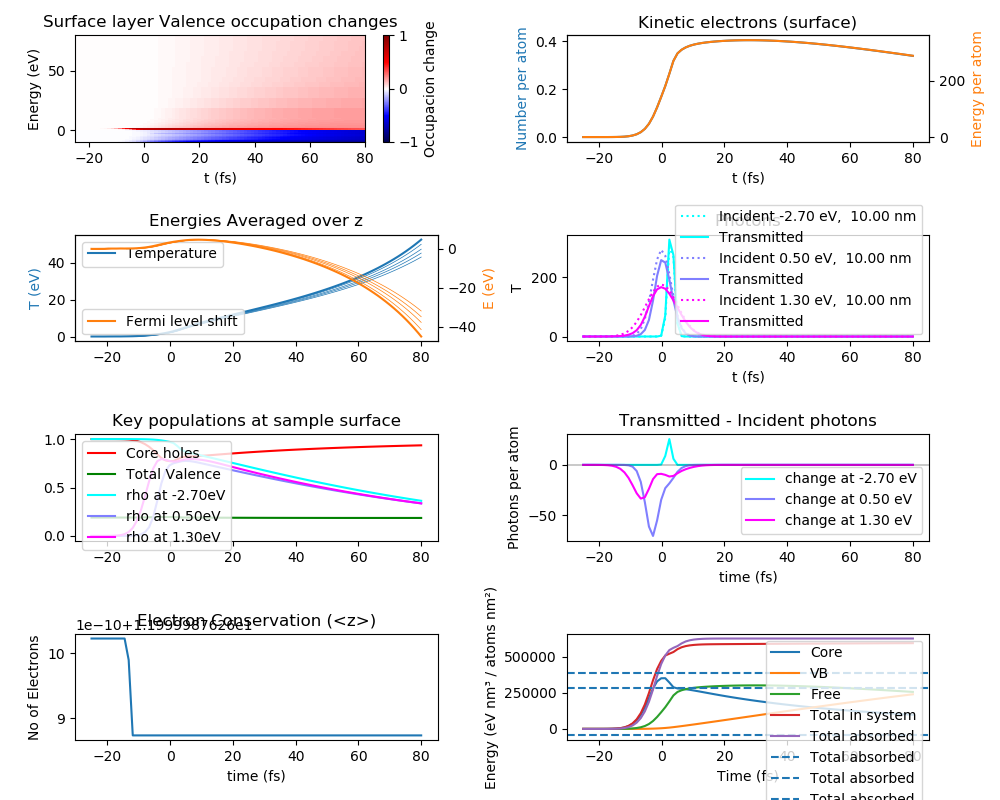

Done


In [8]:
sim.plot_results(sol, sol.photon_densities)

<IPython.core.display.Javascript object>


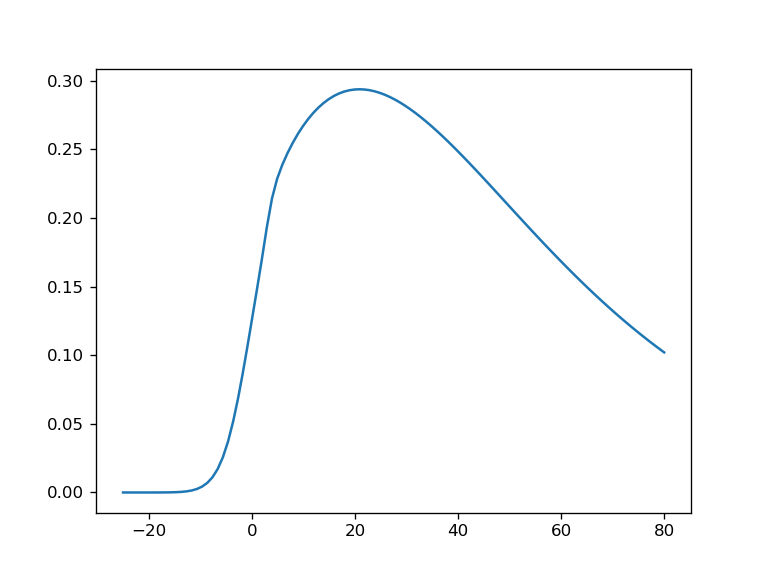

In [15]:
plt.figure()
plt.plot(sol.t, sol.R_free[0])

<IPython.core.display.Javascript object>


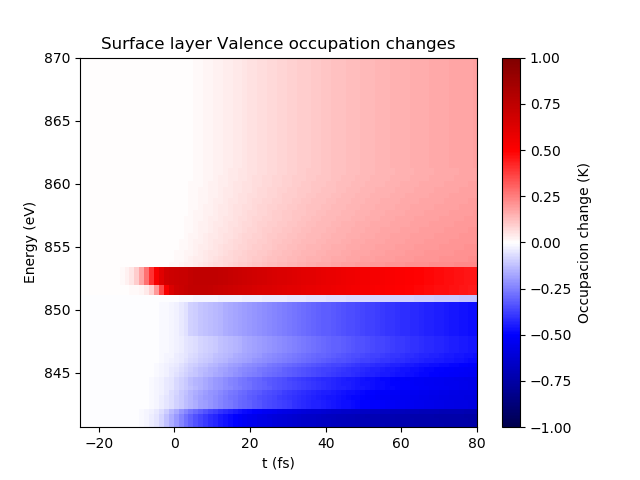

(840.7, 870)

In [13]:
plt.figure()
plt.pcolormesh(sol.t, PAR.E_j +PAR.E_f,
               (sol.rho_j[0]-np.outer(PAR.rho_j_0,np.ones(sol.t.shape)))/np.outer(PAR.m_j,np.ones(sol.t.shape)),
               cmap = plt.cm.seismic, vmin = -1, vmax = 1, shading = 'nearest')#
plt.colorbar(label = 'Occupacion change (K)')
plt.xlabel('t (fs)')
plt.ylabel('Energy (eV)')
plt.title('Surface layer Valence occupation changes')
plt.ylim(None, 870)

<IPython.core.display.Javascript object>


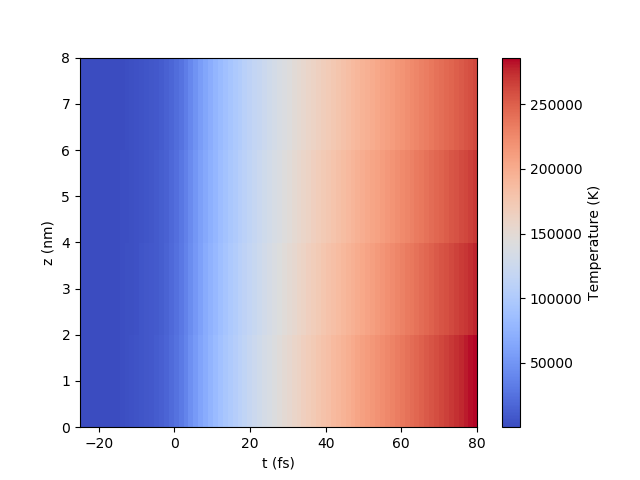

Text(0, 0.5, 'z (nm)')

In [14]:
plt.figure()
plt.pcolormesh(sol.t, PAR.zaxis, sol.temperatures.T, cmap = plt.cm.coolwarm)
plt.colorbar(label = 'Temperature (K)')
plt.xlabel('t (fs)')
plt.ylabel('z (nm)')

<IPython.core.display.Javascript object>


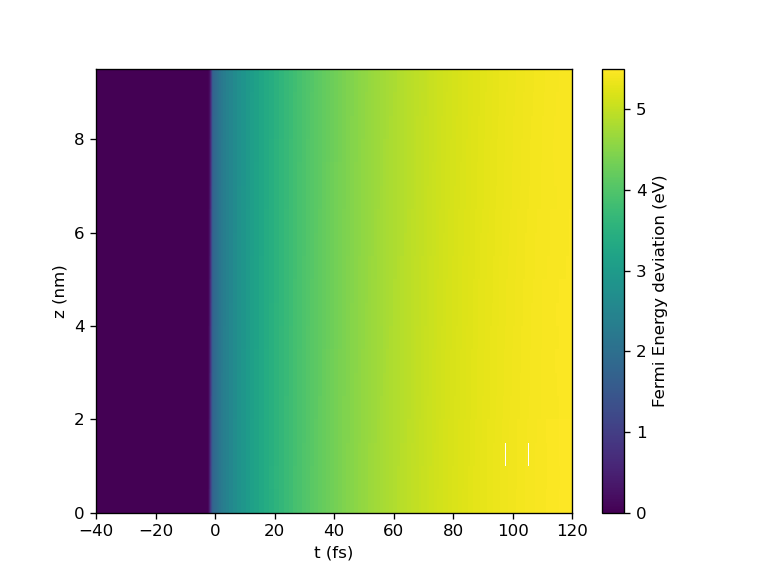

/tmp/ipykernel_186854/203480434.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(sol.t, PAR.zaxis, sol.fermi_energies.T)


Text(0, 0.5, 'z (nm)')

In [35]:
plt.figure()
plt.pcolormesh(sol.t, PAR.zaxis, sol.fermi_energies.T)
plt.colorbar(label = 'Fermi Energy deviation (eV)')
plt.xlabel('t (fs)')
plt.ylabel('z (nm)')

<IPython.core.display.Javascript object>


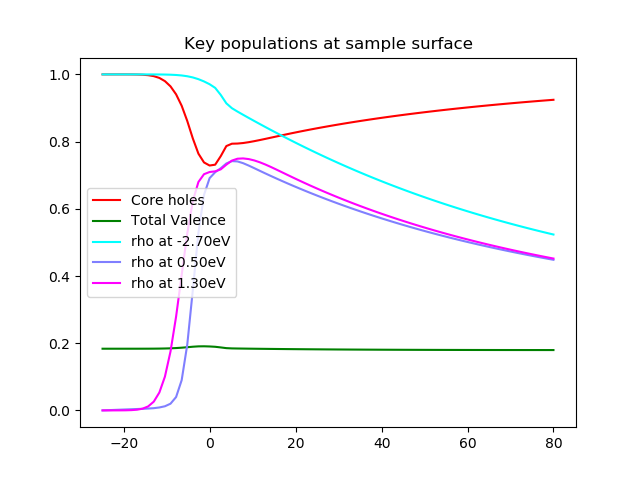

In [15]:
plt.figure()
plt.title('Key populations at sample surface')
plt.plot(sol.t,sol.core[0]/PAR.M_core, c='red', label = 'Core holes')
plt.plot(sol.t,(sol.R_VB[0])/PAR.M_VB, c='green',label = 'Total Valence')
cols = plt.cm.cool(np.linspace(0,1,PAR.N_photens))
for iE,E in enumerate(PAR.E_i):
    plt.plot(sol.t,sol.rho_j[0,PAR.resonant,:][iE].T/PAR.m_j[PAR.resonant][iE],c = cols[iE], label = f'rho at {E:.2f}eV')
plt.legend()


<IPython.core.display.Javascript object>


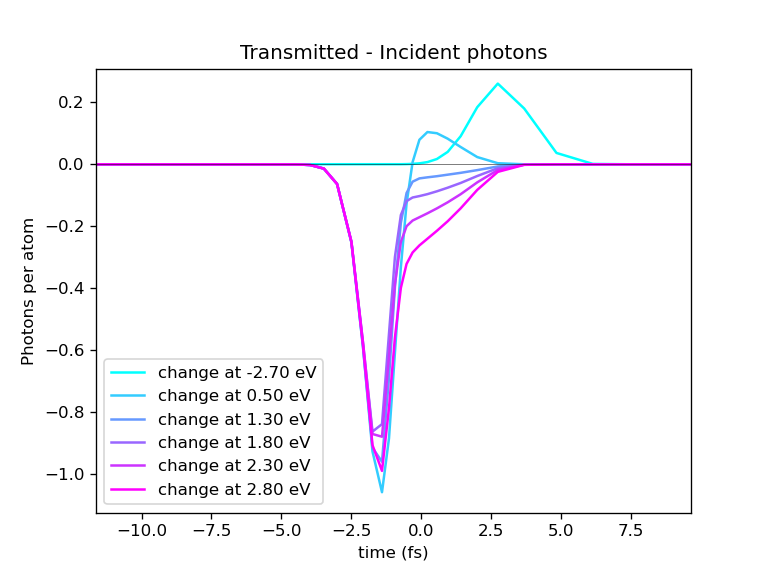

Text(0, 0.5, 'Photons per atom')

In [13]:
T = (sol.photon_densities[-1]-sol.photon_densities[0])#/np.max(sol.photon_densities[0],1)

plt.figure()
for iE,E in enumerate(PAR.E_i):
    plt.plot(sol.t,T[iE],c = cols[iE], label = f'change at {E:.2f} eV')
plt.axhline(c='k', lw = 0.3)
plt.legend()

plt.title('Transmitted - Incident photons')
plt.xlabel('time (fs)')
plt.ylabel('Photons per atom')

In [24]:
PAR.M_core

2

<IPython.core.display.Javascript object>


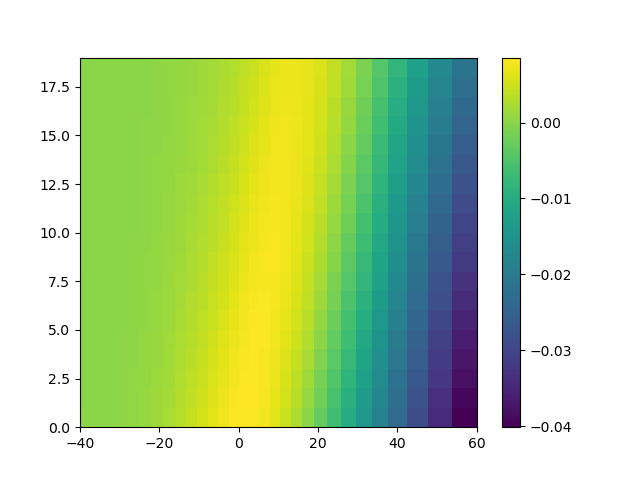

/tmp/ipykernel_121456/52012410.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(sol.t, PAR.zaxis, (sol.R_VB-PAR.R_VB_0)/PAR.M_VB)


In [34]:
plt.figure()
plt.pcolormesh(sol.t, PAR.zaxis, (sol.R_VB-PAR.R_VB_0)/PAR.M_VB)
plt.colorbar()

In [21]:
sol.t.shape

(40,)

In [77]:
def make_valence_energy_axis(self, N_j: int, min=-6, finemax=10, max=50):
        """
        Creates an energy axis for the valence band, namely
            self.E_j
        and its edgepoints
            self.enax_j_edges
        Energies are relative to the fermi-level. 3/4 of all points fall into the range (min, finemax)
        Makes sure that the energies E_i correspond to a point in E_j and
        drops the closest points to keep the number N_j.
        :param N_j:
        :param min:
        :param finemax:
        :param max:
        :return:
        """
        N_j_fine = int(N_j * 3 / 4)
        N_j_coarse = int(N_j - N_j_fine)

        def fill_biggest_gap(pointlist):
            """
            This function takes a list of points and appends a point in the middle of the biggest gap
            """
            pointlist = np.array(np.sort(pointlist))
            gaps = pointlist[1:]-pointlist[:-1]
            biggest_gap_index = np.argsort(gaps)[-1]
            biggest_gap = gaps[biggest_gap_index]
            list_before = pointlist[:biggest_gap_index+1]
            new_value = pointlist[biggest_gap_index] + 0.5*biggest_gap
            list_after = pointlist[biggest_gap_index+1:]
            return np.concatenate((list_before, [new_value,], list_after))
        
        # The energies E_i and 0 must be in the axis
        enax_j_fine = [min, 0, finemax]+list(self.E_i[self.E_i<=finemax])
        # Fill up the gaps
        while len(enax_j_fine)<N_j_fine:
            enax_j_fine = fill_biggest_gap(enax_j_fine)
        
        dE = np.mean(enax_j_fine[1:]-enax_j_fine[:-1])
        #The same for the coarse part
        enax_j_coarse = [finemax+dE, max]+list(self.E_i[self.E_i>finemax])
        while len(enax_j_coarse)<N_j_coarse:
            enax_j_coarse = fill_biggest_gap(enax_j_coarse)
            
        enax_j = np.concatenate((enax_j_fine, enax_j_coarse))

        if not len(enax_j) == N_j:
            warnings.warn(
                'Energy Axis turned out longer or shorter than planned. What went wrong?')
            self.N_j = len(enax_j)
            
        def edgepoints(middles):
            """ Opposite of midpoints """
            edges = np.empty(middles.shape[0] + 1)
            edges[1:-1] = (middles[1:] + middles[:-1]) / 2
            edges[0] = middles[0] - (middles[1] - middles[0]) / 2
            edges[-1] = middles[-1] + (middles[-1] - middles[-2]) / 2
            return edges

        return enax_j, edgepoints(enax_j)

In [55]:
sim.plot_derivatives?

<IPython.core.display.Javascript object>


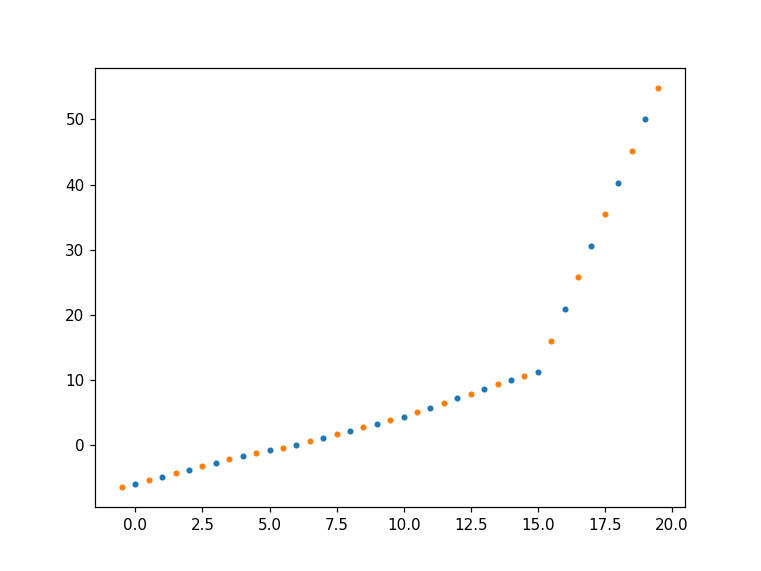

In [82]:
enax, enax_edges = make_valence_energy_axis(PAR, 20, min=-6, finemax=10, max=50)
plt.figure()
plt.plot(np.arange(len(enax)),enax,'.')
plt.plot(np.arange(len(enax_edges))-0.5,enax_edges,'.')